# Data Exploration - NetMob25 Dataset

This notebook demonstrates basic data loading and visualization for the NetMob25 dataset.

In [13]:
import sys
sys.path.append('..')

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ml_mobility_ns3 import NetMob25Loader
from ml_mobility_ns3.utils.visualization import (
    plot_trajectory, plot_multiple_trajectories, create_folium_map
)

# Set style
sns.set_style('darkgrid')
sns.set_palette('husl')

## Load Data

In [14]:
# Initialize data loader
# Use fake data if available, otherwise update path to real NetMob25 data
data_dir = Path("../data/fake_netmob25")  # or Path("../data/netmob25") for real data
if not data_dir.exists():
    print("Data not found! Run 'python generate_fake_data.py' to create fake data.")
    data_dir = Path("../data/netmob25")  # Fallback to real data path

loader = NetMob25Loader(data_dir)

# Load datasets
individuals = loader.load_individuals()
trips = loader.load_trips()

print(f"Loaded {len(individuals)} individuals")
print(f"Loaded {len(trips)} trips")

Loaded 10 individuals
Loaded 1000 trips


## Basic Statistics

In [15]:
# Trips per individual
trips_per_person = trips.groupby('ID').size()
print(f"Average trips per person: {trips_per_person.mean():.2f}")
print(f"Median trips per person: {trips_per_person.median():.0f}")

# Trip duration distribution
trip_durations = trips['Duration'].dropna()
print(f"\nAverage trip duration: {trip_durations.mean():.2f} minutes")
print(f"Median trip duration: {trip_durations.median():.2f} minutes")

Average trips per person: 100.00
Median trips per person: 68

Average trip duration: 31.61 minutes
Median trip duration: 29.28 minutes


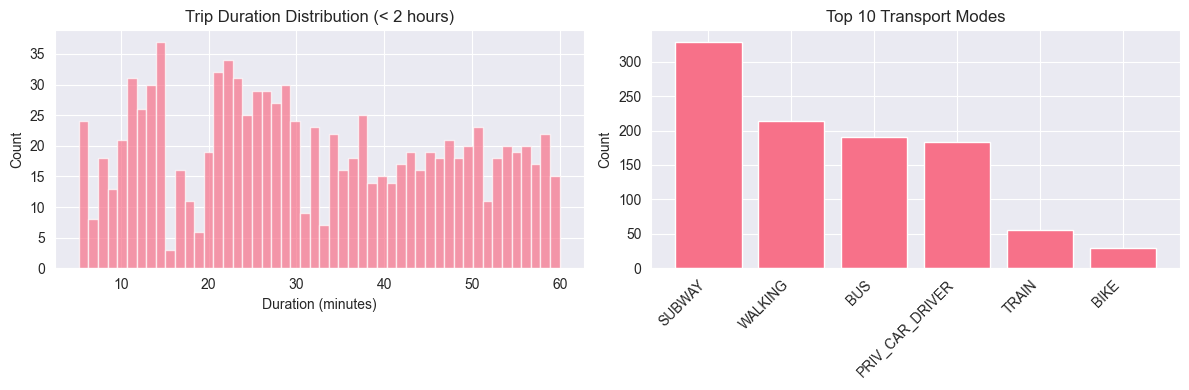

In [16]:
# Plot trip duration distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
ax1.hist(trip_durations[trip_durations < 120], bins=50, alpha=0.7)
ax1.set_xlabel('Duration (minutes)')
ax1.set_ylabel('Count')
ax1.set_title('Trip Duration Distribution (< 2 hours)')

# Transport modes
mode_counts = trips['Main_Mode'].value_counts().head(10)
ax2.bar(range(len(mode_counts)), mode_counts.values)
ax2.set_xticks(range(len(mode_counts)))
ax2.set_xticklabels(mode_counts.index, rotation=45, ha='right')
ax2.set_ylabel('Count')
ax2.set_title('Top 10 Transport Modes')

plt.tight_layout()
plt.show()

## Sample Trajectories

Sampled 5 trajectories


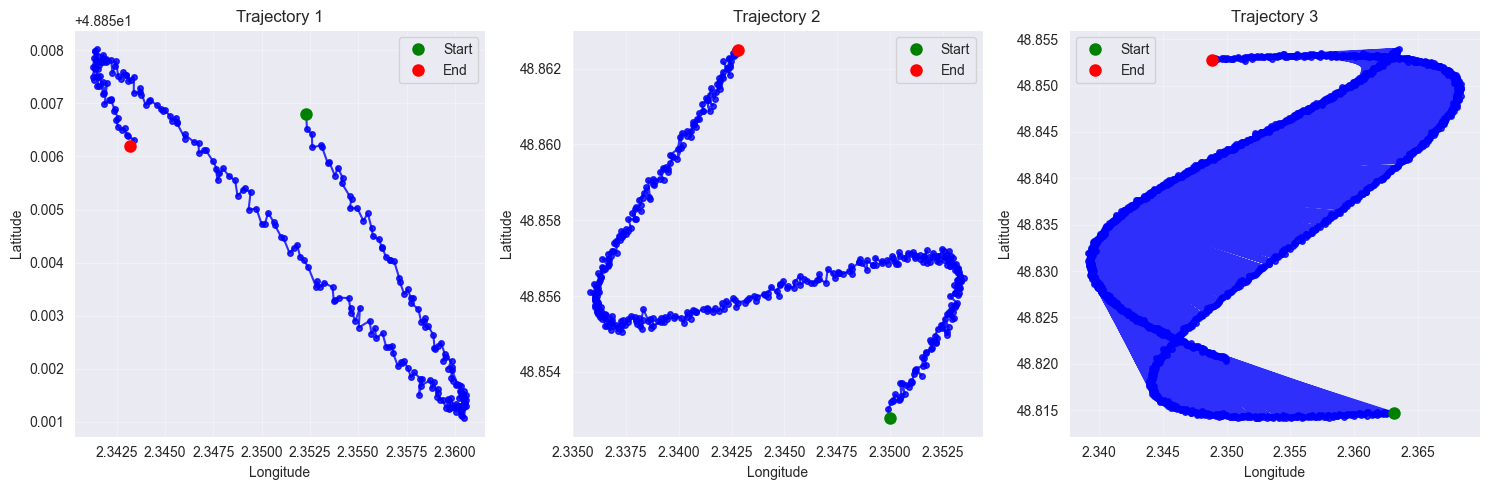

In [17]:
# Sample some trajectories
sample_trajectories = loader.sample_trajectories(n_samples=5, min_points=20)
print(f"Sampled {len(sample_trajectories)} trajectories")

# Plot individual trajectories
fig, axes = plt.subplots(1, min(3, len(sample_trajectories)), figsize=(15, 5))
if len(sample_trajectories) == 1:
    axes = [axes]

for i, (ax, traj) in enumerate(zip(axes, sample_trajectories[:3])):
    plot_trajectory(traj, ax=ax, title=f'Trajectory {i+1}')
    
plt.tight_layout()
plt.show()

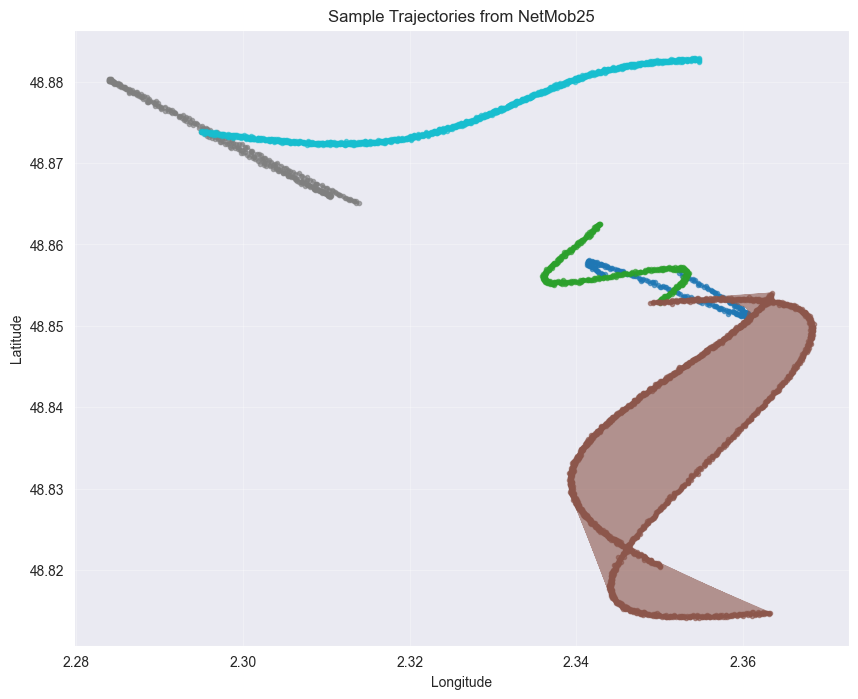

In [18]:
# Plot multiple trajectories together
if len(sample_trajectories) > 1:
    fig = plot_multiple_trajectories(
        sample_trajectories[:10],
        title="Sample Trajectories from NetMob25"
    )
    plt.show()

## Interactive Map

In [19]:
len(sample_trajectories)

5

In [20]:
# Create interactive map
if len(sample_trajectories) > 0:
    m = create_folium_map(sample_trajectories[:5])
    m  # Display the map

In [23]:
m

## Trajectory Statistics

In [21]:
# Analyze trajectory characteristics
traj_stats = []

for traj in sample_trajectories[:20]:
    if len(traj) > 0:
        # Calculate distance
        lat_diff = traj['LATITUDE'].max() - traj['LATITUDE'].min()
        lon_diff = traj['LONGITUDE'].max() - traj['LONGITUDE'].min()
        
        # Time span
        time_span = (traj['UTC_TIMESTAMP'].max() - traj['UTC_TIMESTAMP'].min()).total_seconds() / 60
        
        # Average speed
        avg_speed = traj['SPEED'].mean() if 'SPEED' in traj.columns else 0
        
        traj_stats.append({
            'n_points': len(traj),
            'lat_range': lat_diff,
            'lon_range': lon_diff,
            'duration_min': time_span,
            'avg_speed': avg_speed
        })

stats_df = pd.DataFrame(traj_stats)
print("Trajectory Statistics:")
print(stats_df.describe())

Trajectory Statistics:
          n_points  lat_range  lon_range  duration_min  avg_speed
count     5.000000   5.000000   5.000000      5.000000   5.000000
mean    797.400000   0.016526   0.031206     25.780107   5.087568
std     678.716657   0.013373   0.016920     17.327734   3.996226
min     241.000000   0.006958   0.017688      9.989472   1.388104
25%     336.000000   0.009751   0.019329     13.958198   1.388984
50%     409.000000   0.010766   0.029318     16.994709   4.172285
75%    1200.000000   0.015319   0.029921     37.966114   8.495812
max    1801.000000   0.039835   0.059774     49.992041   9.992654
